In [ ]:
###Readme
###Run the entire Jupyter on Ondemand HPC, using Kernel Python3, the general environment.
###Please see all figures in the Jupternotebook and code for training, testing optimization
###see the logs in logfile

In [ ]:
!module load anaconda/2021.11
!module load cuda/12.2
!nvidia-smi
!nvcc --version

Fri Mar  1 15:36:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L40S                    On  | 00000000:3F:00.0 Off |                    0 |
| N/A   51C    P0             101W / 350W |   4357MiB / 46068MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install torchvision

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/cluster/tufts/hpc/tools/anaconda/202105/bin/python -m pip install --upgrade pip' command.


In [ ]:
### ARCH2

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import pandas as pd


In [ ]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(32 * 16 * 16, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(-1, 32 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


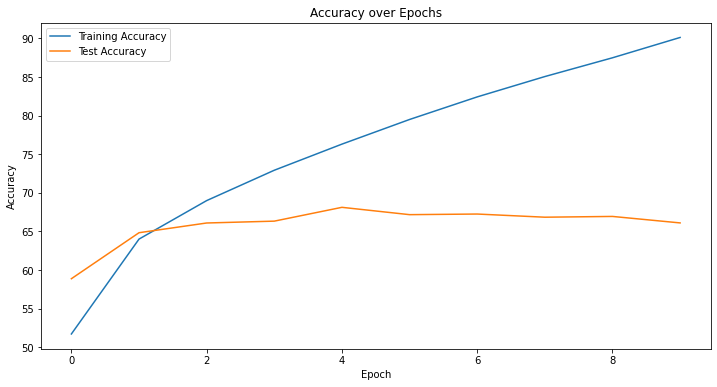

Finished Training


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = CustomCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


epochs = 10
log_interval = 200
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

# Training and real-time plotting
for epoch in range(epochs):
    model.train()
    running_loss, train_correct, train_total = 0.0, 0, 0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    train_accuracy = 100 * train_correct / train_total
    train_accuracies.append(train_accuracy)

    # Test accuracy evaluation
    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    test_accuracy = 100 * test_correct / test_total
    test_accuracies.append(test_accuracy)

    # Real-time plotting
    clear_output(wait=True)
    plt.figure(figsize=(12, 6))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.show()

print('Finished Training')



In [ ]:
torch.save(model.state_dict(), './model_architecture_2.pth')

# Save log to a file (example)
df.to_csv('./training_log.csv', index=False)


In [ ]:
### hyperparameter tuning

In [ ]:
!pip install optuna

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 413 kB 7.6 MB/s            
     |████████████████████████████████| 233 kB 147.2 MB/s            
     |████████████████████████████████| 78 kB 2.4 MB/s              
You should consider upgrading via the '/cluster/tufts/hpc/tools/anaconda/202105/bin/python -m pip install --upgrade pip' command.


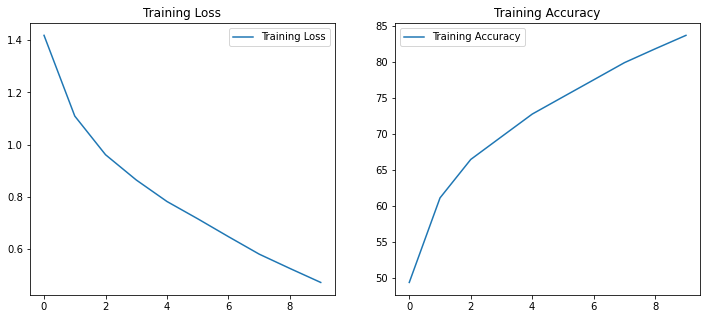

Epoch [10/10], Loss: 0.4720, Accuracy: 83.65%


[I 2024-03-01 15:19:00,793] Trial 4 finished with value: 0.6742 and parameters: {'lr': 0.0009787039087869672, 'batch_size': 128}. Best is trial 1 with value: 0.676.


Files already downloaded and verified
Files already downloaded and verified


[W 2024-03-01 15:19:04,868] Trial 5 failed with parameters: {'lr': 0.0007108221344662495, 'batch_size': 64} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/cluster/home/rchu02/.local/lib/python3.8/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-18-4dd5f6bb2b6a>", line 41, in objective
    for i, data in enumerate(trainloader, 0):
  File "/cluster/home/rchu02/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 644, in __next__
    return data
  File "/cluster/home/rchu02/.local/lib/python3.8/site-packages/torch/autograd/profiler.py", line 622, in __exit__
    torch.ops.profiler._record_function_exit._RecordFunction(record)
  File "/cluster/home/rchu02/.local/lib/python3.8/site-packages/torch/_ops.py", line 513, in __call__
    return self._op(*args, **(kwargs or {}))
KeyboardInterrupt
[W 2024-03-01 15:19:04,883] Trial 5 failed with value None.


KeyboardInterrupt: 

In [ ]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np



def objective(trial):
    # Hyperparameters to tune
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])

    # Data loaders with dynamic batch size
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)


    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = CustomCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    epochs = 10

    train_losses, train_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(trainloader)
        epoch_accuracy = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Real-time plotting
        clear_output(wait=True)
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.title('Training Loss')
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(train_accuracies, label='Training Accuracy')
        plt.title('Training Accuracy')
        plt.legend()
        plt.show()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')


    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print("Best trial:")
trial = study.best_trial

print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"  {key}: {value}")


In [ ]:
### Arch 1

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
import numpy as np


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load CIFAR10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 10)  # Adjusting for CIFAR10
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


/cluster/home/rchu02/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/cluster/home/rchu02/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


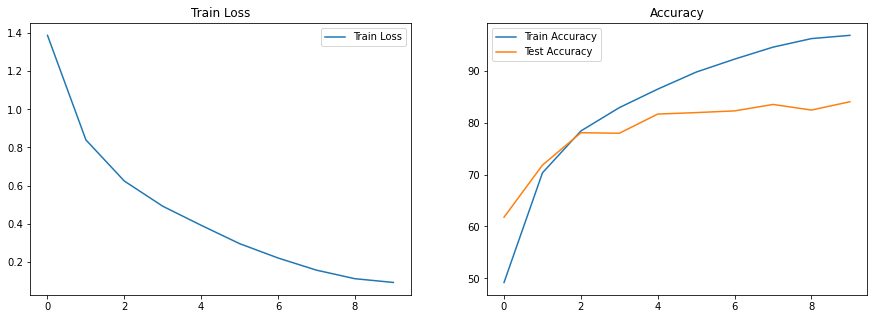

Epoch 10/10 - Train Loss: 0.0914, Train Acc: 96.77, Test Acc: 84.00


In [ ]:
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    model.train()
    stats = {'train_loss': [], 'train_acc': [], 'test_acc': []}

    for epoch in range(epochs):
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total

        # Evaluate on test set
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        test_acc = 100 * correct / total

        # Update stats
        stats['train_loss'].append(train_loss)
        stats['train_acc'].append(train_acc)
        stats['test_acc'].append(test_acc)

        # Real-time plotting
        clear_output(wait=True)
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.plot(stats['train_loss'], label='Train Loss')
        plt.title('Train Loss')
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(stats['train_acc'], label='Train Accuracy')
        plt.plot(stats['test_acc'], label='Test Accuracy')
        plt.title('Accuracy')
        plt.legend()
        plt.show()

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}, Test Acc: {test_acc:.2f}")

        # back to train mode
        model.train()

    return model, stats

# Train the model
model, stats = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10)

# Save the model
torch.save(model.state_dict(), 'model_architecture_1.pth')

# Save training stats

with open('training_stats.csv', 'w') as f:
    f.write('Epoch,Train Loss,Train Accuracy,Test Accuracy\n')
    for i in range(len(stats['train_loss'])):
        f.write(f"{i+1},{stats['train_loss'][i]},{stats['train_acc'][i]},{stats['test_acc'][i]}\n")


In [ ]:
### END